# **run load_data.ipynb BEFORE running this!**

In [2]:
from data import data_folder_dictionary
data_folder_dictionary['temperature_230509_discrete']

'5.9.23/'

In [2]:
from settings import siamese_settings_dictionary as settings
from settings import information
information(settings)
ways = settings['number of ways']
shot = settings['number of shots']
print(f"{ways}-way-{shot}-shot")

the problem type is: regression
this file uses the few-shot learning with non-parametric using siamese network
the goal is to learn a distribution using few samples from it
the inputs are: samples from a distribution; they are vectors that represent spectrum
the outputs are: samples from a distribution; they are one number that represent temperature or pressure, depending on distribution
2-way-1-shot


In [3]:
import numpy as np
from data import data_file_dictionary as dfd
from data_accesor import get_raw_data
print("LOADING RAW DATA_____________________________________")
raw_input_1, raw_label_1 = get_raw_data(
    dfd['temperature']['folder for data'], "temperature")
raw_input_2, raw_label_2 = get_raw_data(
    dfd['pressure']['folder for data'], "pressure")
print("LOADING RAW INDICES__________________________________")
from data_accesor import get_cross_validation_indices
train_indices_1, valid_indices_1, test_indices_1 = get_cross_validation_indices(
    dfd['temperature']['folder for indices'], "temperature")
train_indices_2, valid_indices_2, test_indices_2 = get_cross_validation_indices(
    dfd['pressure']['folder for indices'], "pressure")

LOADING RAW DATA_____________________________________
type of data: temperature
	number of examples: 6000
	raw input shape: (6000, 10000), dimension 10000
	raw output shape: (6000, 1), dimension 1
type of data: pressure
	number of examples: 5000
	raw input shape: (5000, 10000), dimension 10000
	raw output shape: (5000, 1), dimension 1
LOADING RAW INDICES__________________________________
type of data: temperature
	there are 16 folds
	3500 for training, 500 for validating, 1000 for testing
type of data: pressure
	there are 16 folds
	4200 for training, 600 for validating, 1200 for testing


In [ ]:
# task layout:
# support set has [ways] distributions; for each, get [shot] samples & their labels
# query set has 1 sample & its label from a distribution NOT in support set 

# goal: given one input, need its output
# query set: the input (and its output, during training)
# NOTE: query and support sets have DIFFerent distributions (so support set doesn't 'cheat')
# support set: for the input's distribution, have <shot> samples (and their labels)
# model learns the input's distribution from support set; 
# then it usese it to regress on the input, producing the output
# in this case, the learning is done with siamese network

[0.928 0.912 0.88  0.848 0.824 0.824 0.832 0.856 0.872 0.872]
[0.86  0.852 0.876 0.876 0.876 0.884 0.876 0.876 0.876 0.844]


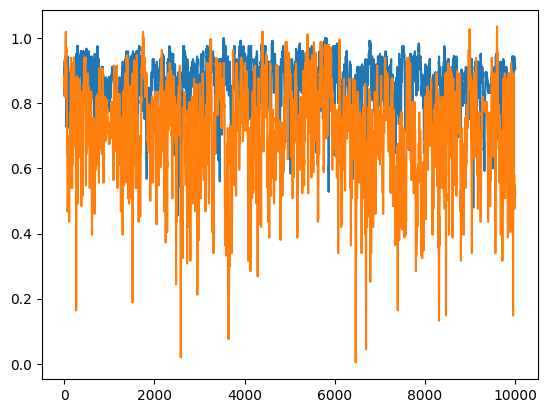

In [4]:
import matplotlib.pyplot as plt
print(raw_input_1[0][0:10])
plt.plot(raw_input_1[0])
print(raw_input_2[0][0:10])
plt.plot(raw_input_2[0])

In [109]:
# how many parameters?
#   "a very simple two-layer ReLU network with p = 2n + d parameters 
#   that can express any labeling of any sample of size n in d dimensions
#   https://arxiv.org/pdf/1611.03530.pdf
#   https://stats.stackexchange.com/questions/320383/relationship-between-
#   model-over-fitting-and-number-of-parameters/320387#320387
import torch
import torch.nn as nn
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

feature_dimension = 32
class SiameseModel(torch.nn.Module):
    def __init__(self, device, input_dim=input_dimension):
        super().__init__()
        self.relu  = nn.ReLU()
        self.hidden_dim = 32
        self.feature_dim = feature_dimension
        self.output_dim = output_dimension
        # siamese part
        self.sequential = torch.nn.Sequential(
            torch.nn.Linear(input_dim, self.hidden_dim),
            self.relu,
            # torch.nn.Dropout(0.2),
            torch.nn.Linear(self.hidden_dim, self.hidden_dim),
            self.relu,
            # torch.nn.Dropout(0.2),
            torch.nn.Linear(self.hidden_dim, self.feature_dim)
        )
        self.device = device
        self.to(device)
        self.float()
    def forward(self, input):
        feature = self.sequential(input)
        return feature
class RegressionModel(torch.nn.Module):
    def __init__(self, device, input_dim=feature_dimension):
        super().__init__()
        self.relu  = nn.ReLU()
        self.feature_dim = feature_dimension
        self.output_dim = output_dimension
        self.intermediate_dim = feature_dimension
        self.sequential = torch.nn.Sequential(
            torch.nn.Linear(input_dim, self.intermediate_dim),
            self.relu,
            torch.nn.Linear(self.intermediate_dim, self.intermediate_dim),
            self.relu,
            torch.nn.Linear(self.intermediate_dim, self.intermediate_dim),
            self.relu,
            torch.nn.Linear(self.intermediate_dim, self.output_dim)
        )
        self.device = device
        self.to(device)
        self.float()
    def forward(self, feature):
        output = self.sequential(feature)
        return output

In [110]:
# add scheduler
# https://arxiv.org/abs/1711.05101
# Adam can substantially benefit from a scheduled learning rate multiplier. 
# The fact that Adam is an adaptive gradient algorithm and as such adapts 
# the learning rate for each parameter does not rule out the possibility to 
# substantially improve its performance by using a global learning rate 
# multiplier, scheduled, e.g., by cosine annealing.
class Scheduler():
    def __init__(self, optimizer, patience, minimum_learning_rate, factor):
        # wait 'patience' number of epochs to change learning rate
        # learning rates' lower bound: 'minimum_learning_rate'
        # update learning rate by 'factor'ArithmeticError
        self.optimizer = optimizer
        self.patience = patience
        self.minimum_learning_rate = minimum_learning_rate
        self.factor = factor
        # use 'min' mode because:
        # we are monitoring loss
        # we do stuff when loss stops DEcreasing
        self.scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer=self.optimizer, mode='min', patience=self.patience,
            factor=self.factor, min_lr=self.minimum_learning_rate,
        )
        # print(f"SCHEDULER: {self.scheduler}:")
        # print(f"\tpatience = {self.patience}, factor = {self.factor}" + 
        #       f"minimum_learning_rate = {minimum_learning_rate}")
    def __call__(self, validation_loss):
        self.scheduler.step(validation_loss)

In [111]:
# early stopping (patience step)
# https://debuggercafe.com/using-learning-rate-scheduler-and-early-stopping
# -with-pytorch/
class EarlyStopping():
    def __init__(self, patience, min_delta):
        # if no improvement after 'patience' epochs, stop training
        # to count as improvement, need to change by 'min_delta' amount
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
    def __call__(self, loss):
        if self.best_loss == None:
            self.best_loss = loss
        elif self.best_loss - loss >= self.min_delta:
            # improved enough
            self.best_loss = loss
            self.counter = 0
        elif self.best_loss - loss < self.min_delta:
            # did NOT improve enough :C
            self.counter += 1
            if self.counter >= self.patience:
                # it's stopping time! :C
                # no need reset early_stop, because we only use it once
                self.early_stop = True 

In [112]:
class SaveBestModel():
    def __init__(self, current_best_loss = float('inf')):
        self.current_best_loss = current_best_loss
        self.itsSavingTime = False
    def __call__(self, current_loss, model_1, model_2, round):
        # no save optimizer, since we are using model for inference
        if current_loss < self.current_best_loss:
            self.current_best_loss = current_loss
            self.itsSavingTime = True
        if self.itsSavingTime == True:
            torch.save(model_1.state_dict(), PATH + f'fea_round={round}' + '.pth')
            torch.save(model_2.state_dict(), PATH + f'reg_round={round}' + '.pth')
# inherits from SaveBestModel
class SaveBestModel_filename(SaveBestModel):
    def __init__(self, current_best_loss = float('inf')):
        SaveBestModel.__init__(self, current_best_loss = float('inf'))
    def __call__(self, current_loss, round):
        # no save optimizer, since we are using model for inference
        if current_loss < self.current_best_loss:
            self.current_best_loss = current_loss
            self.current_best_model_1_filename = PATH + f'fea_round={round}' + '.pth'
            self.current_best_model_2_filename = PATH + f'reg_round={round}' + '.pth'

In [113]:
import random
import copy
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
# reference:
# https://colab.research.google.com/github/maticvl/dataHacker/
# blob/master/pyTorch/014_siameseNetwork.ipynb#scrollTo=gD1BFFm_z7aj
class SiameseDataset(torch.utils.data.TensorDataset):
    def __init__(self, X, y):
        # X is already normalized
        self.y_raw = y
        self.y = torch.Tensor(
            preprocessing.normalize(np.copy(y), axis=0)).to(device)
        # self.y = y
        self.X = torch.Tensor(
            preprocessing.normalize(np.copy(X), axis=1)).to(device)
        self.indices = range(len(y))
    def __len__(self):
        return len(self.y)
    def __getitem__(self, index): # assume index lies within subset_X_IDs
        input_1_id = index
        input_1 = self.X[input_1_id]
        label_1 = self.y[input_1_id]
        label_1_raw = self.y_raw[input_1_id]
        input_2_id = random.choice(self.indices)
        input_2 = self.X[input_2_id]
        label_2 = self.y[input_2_id]
        label_2_raw = self.y_raw[input_2_id]
        return input_1, input_2, label_1, label_2, label_1_raw, label_2_raw

In [114]:
import torch.nn.functional as F
class FeatureLoss(torch.nn.Module):
    def __init__(self):
        super(FeatureLoss, self).__init__()

    def forward(self, feature_1, feature_2, label_1, label_2):
        mse = nn.MSELoss()
        feature_distance = mse(feature_1, feature_2)
        # print(feature_distance)
        label_distance = mse(label_1, label_2)
        # print(label_distance)
        return abs(feature_distance - label_distance)

In [115]:
# Trying to backward through the graph a second time 
# (or directly access saved tensors after they have already been freed). 
# Saved intermediate values of the graph are freed when 
# you call .backward() or autograd.grad(). 
# Specify retain_graph=True if you need to backward through the graph a 
# second time or if you need to access saved tensors after calling backward

In [116]:
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torch import optim
import numpy as np

# return: train_loss, validation_loss, current model
class trainer():
    def __init__(self, feature_model, regress_model, 
                 n_epochs, batch_size, 
                 feature_learning_rate,
                 regress_learning_rate,
                 cross_validation_round):
        super().__init__()
        self.batch_size = batch_size
        self.n_epochs = n_epochs
        self.cross_validation_round = cross_validation_round
        self.device = device

        self.feature_learning_rate = feature_learning_rate
        self.feature_model = feature_model
        self.feature_model.apply(self.initializer)
        self.feature_optimizer = optim.AdamW(
                        self.feature_model.parameters(), 
                        lr=feature_learning_rate, 
                        weight_decay=6e-3) 
        self.feature_scheduler = Scheduler(optimizer=self.feature_optimizer, 
                        minimum_learning_rate=1e-6,
                        patience=5,
                        factor=0.5)
        self.feature_criterion = FeatureLoss()
        self.feature_stopper = EarlyStopping(patience=5, min_delta=1e-6)
        
        self.regress_learning_rate = regress_learning_rate
        self.regress_model = regress_model
        self.regress_model.apply(self.initializer)
        self.regress_optimizer = optim.AdamW(
                        self.regress_model.parameters(), 
                        lr=regress_learning_rate, 
                        weight_decay=6e-3) 
        self.regress_scheduler = Scheduler(optimizer=self.regress_optimizer, 
                        minimum_learning_rate=1e-6,
                        patience=5,
                        factor=0.5)
        self.regress_criterion = nn.MSELoss()
        self.regress_stopper = EarlyStopping(patience=5, min_delta=1e-6)
        
        
    # use He initialization (because of RELU units in model definition)  
    def initializer(self, layer):
        if type(layer) == nn.Linear:
            nn.init.kaiming_normal_(layer.weight) # normal version
    def get_loss(self, train_data, train_label, test_data, test_label):
        # datasets
        train_set = SiameseDataset(train_data, train_label)
        val_set = SiameseDataset(test_data, test_label)
        # dataloaders
        loader_args = dict(batch_size=self.batch_size)
        train_loader = DataLoader(train_set, shuffle=True, drop_last=True, 
                                  **loader_args)
        valid_loader = DataLoader(val_set, shuffle=True, drop_last=True, 
                                **loader_args)
        """SETUP"""
        feature_train_loss = []
        feature_valid_loss = []
        regress_train_loss = []
        regress_valid_loss = []
        feature_stopped_saidso = False
        stopper = EarlyStopping(patience=5, min_delta=1e-6)

        # scheduler action affects the optimizer!
        saver = SaveBestModel()

        for epoch in range(0, self.n_epochs):
            # training
            feature_train_loss_thisepoch = []
            regress_train_loss_thisepoch = []
            
            for i, data in enumerate(train_loader, 0):
                x1, x2, y1, y2, y1_raw, y2_raw = data
                # get features
                f1 = self.feature_model(x1.to(self.device))
                f2 = self.feature_model(x2.to(self.device))
                """update regress model"""
                y1_pred = self.regress_model(f1.to(self.device))
                # when loss function called, pytorch calculate gradient
                # this is done once (removes computing graph)
                regress_loss = self.regress_criterion(
                    y1_pred.to(self.device).float(), 
                    y1_raw.to(self.device).float())
                self.regress_optimizer.zero_grad()
                regress_loss.backward(retain_graph=True)
                self.regress_optimizer.step()
                regress_train_loss_thisepoch.append(regress_loss.item())
                # trying to calculate loss again, but for same model?
                # need to KEEP computing graph, so retain_graph=True
                """update feature model"""
                feature_loss = self.feature_criterion(
                    f1.to(self.device).float(), 
                    f2.to(self.device).float(), 
                    y1.to(self.device).float(), 
                    y2.to(self.device).float())
                real_feature_loss = feature_loss + 0
                # stop training feature model if loss converged
                self.feature_optimizer.zero_grad()
                real_feature_loss.backward()
                self.feature_optimizer.step()
                feature_train_loss_thisepoch.append(real_feature_loss.item())
            feature_train_loss.append(np.mean(feature_train_loss_thisepoch))
            regress_train_loss.append(np.mean(regress_train_loss_thisepoch))

            # validation
            feature_valid_loss_thisepoch = []
            regress_valid_loss_thisepoch = []
            for i, data in enumerate(valid_loader, 0):
                with torch.no_grad():
                    x1, x2, y1, y2, y1_raw, y2_raw = data
                    # print(f"validate: shape of x1: {x1.shape}")
                    f1 = self.feature_model(x1.to(self.device))
                    f2 = self.feature_model(x2.to(self.device))

                    y1_pred = self.regress_model(f1.to(self.device))
                    regress_loss = self.regress_criterion(
                        y1_pred.to(self.device), 
                        y1_raw.to(self.device))
                    regress_valid_loss_thisepoch.append(regress_loss.item())

                    feature_loss = self.feature_criterion(
                            f1.to(self.device), 
                            f2.to(self.device), 
                            y1.to(self.device), 
                            y2.to(self.device))
                    real_feature_loss = feature_loss + 0
                    feature_valid_loss_thisepoch.append(real_feature_loss.item())
            feature_valid_loss.append(np.mean(feature_valid_loss_thisepoch))
            regress_valid_loss.append(np.mean(regress_valid_loss_thisepoch))
            # save best model
            saver(current_loss=np.mean(regress_valid_loss), 
                  model_1=self.feature_model, 
                  model_2=self.regress_model,
                  round=self.cross_validation_round
                  )
            # scheduler & early stopping
            self.feature_scheduler(np.mean(feature_valid_loss_thisepoch))
            self.regress_scheduler(np.mean(regress_valid_loss_thisepoch))
            
            total_loss = np.mean(feature_valid_loss_thisepoch) + np.mean(regress_valid_loss_thisepoch)
            stopper(total_loss)
            if stopper.early_stop == True:
                print(f"EARLY STOPPING @ epoch {epoch}")
                break
            # self.feature_stopper(np.mean(feature_valid_loss_thisepoch))
            # if self.feature_stopper.early_stop == True:
            #     if feature_stopped_saidso == False:
            #         print(f"\tfeature EARLY STOPPING @ epoch {epoch}")
            #         feature_stopped_saidso = True
                
            # self.regress_stopper(np.mean(regress_valid_loss_thisepoch))
            # if self.regress_stopper.early_stop == True:
            #     print(f"\tregress EARLY STOPPING @ epoch {epoch}")
            #     break
        # plot result w.r.t epoch
        #plot feature
        plt.subplot(1, 2, 1)
        plt.plot(feature_train_loss)
        plt.plot(feature_valid_loss)
        plt.legend(["feature train loss", "feature valid loss"], 
                   loc ="upper right")
        plt.title("FEATURE")
        #plot regression
        plt.subplot(1, 2, 2)
        plt.plot(regress_train_loss)
        plt.plot(regress_valid_loss)
        plt.legend(["regress train loss", "regress valid loss"], 
                   loc ="upper right")
        plt.title("REGRESS")
        plt.show()
        min_feature_valid_loss = np.min(feature_valid_loss)
        min_feature_train_loss = np.min(feature_train_loss)
        min_regress_valid_loss = np.min(regress_valid_loss)
        min_regress_train_loss = np.min(regress_train_loss)
        return min_feature_valid_loss, min_feature_train_loss, self.feature_model, min_regress_valid_loss, min_regress_train_loss, self.regress_model

it's training time
feature network params ct:
	necessary params count: 22000
	actual params count: 322144
regress network params ct:
	necessary params count: 12032
	actual params count: 3201
number of epochs: 2000, batch size: 128, device: cuda, learning rates: 5e-05, 5e-05

training starts:
cross-validation round no.0
EARLY STOPPING @ epoch 95


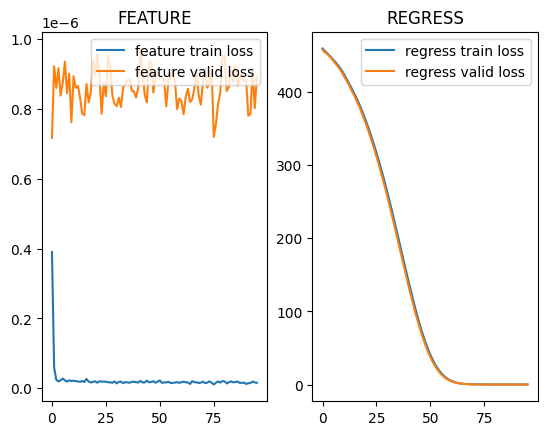

	minimum feature train loss:      1.066122745640996e-08
	minimum feature valid loss:      7.173482572397916e-07
		feature val/train: 67.28570984652362
	minimum regress train loss:      0.14971205545589328
	minimum regress valid loss:      0.1363730211855669
		regress val/train: 0.910902069778501
	time: 2023-06-05 16:50:10
cross-validation round no.1
EARLY STOPPING @ epoch 88


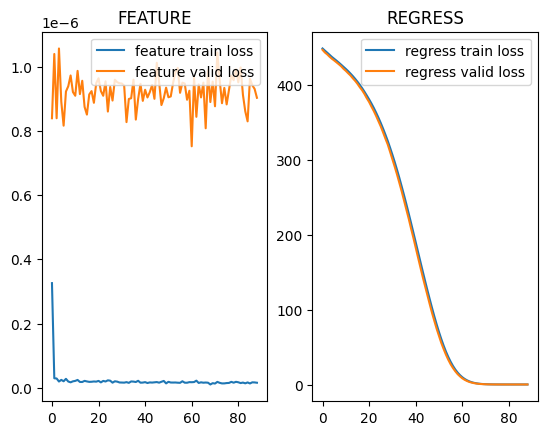

	minimum feature train loss:      1.0130419614284847e-08
	minimum feature valid loss:      7.517997033801294e-07
		feature val/train: 74.21209900525946
	minimum regress train loss:      0.1528100478462875
	minimum regress valid loss:      0.14844742647091655
		regress val/train: 0.9714506903383779
	time: 2023-06-05 16:50:58
cross-validation round no.2
EARLY STOPPING @ epoch 102


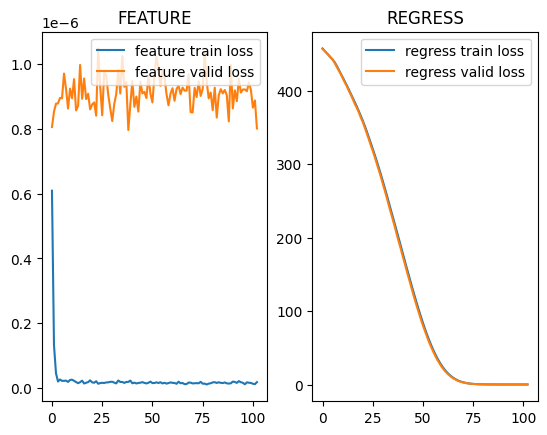

	minimum feature train loss:      1.123546944370446e-08
	minimum feature valid loss:      7.960111929605773e-07
		feature val/train: 70.84805819187235
	minimum regress train loss:      0.15115394489839673
	minimum regress valid loss:      0.1457537666738709
		regress val/train: 0.9642736534057663
	time: 2023-06-05 16:51:53
cross-validation round no.3
EARLY STOPPING @ epoch 114


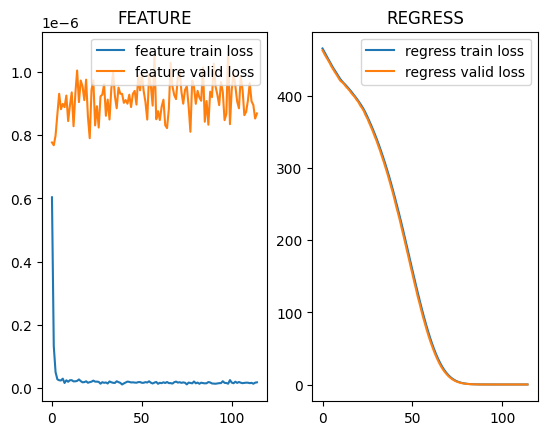

	minimum feature train loss:      1.1140642630635966e-08
	minimum feature valid loss:      7.679654459025187e-07
		feature val/train: 68.93367567420832
	minimum regress train loss:      0.1504934581462294
	minimum regress valid loss:      0.1476342801911564
		regress val/train: 0.9810013140086473
	time: 2023-06-05 16:52:54
cross-validation round no.4
EARLY STOPPING @ epoch 82


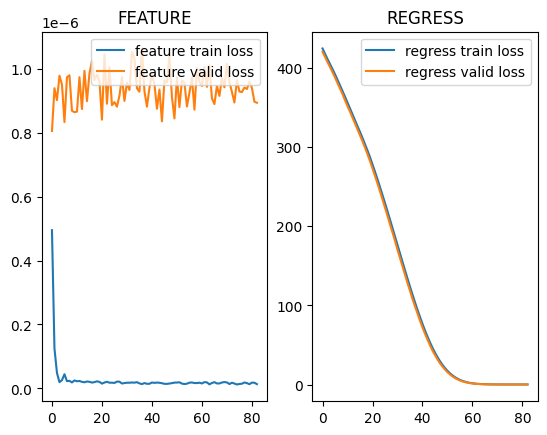

	minimum feature train loss:      1.2355510836670192e-08
	minimum feature valid loss:      8.051579811763077e-07
		feature val/train: 65.16589980129851
	minimum regress train loss:      0.14932029717601836
	minimum regress valid loss:      0.15106345699692655
		regress val/train: 1.0116739643161397
	time: 2023-06-05 16:53:38

training and validation loss, across cross-validation rounds


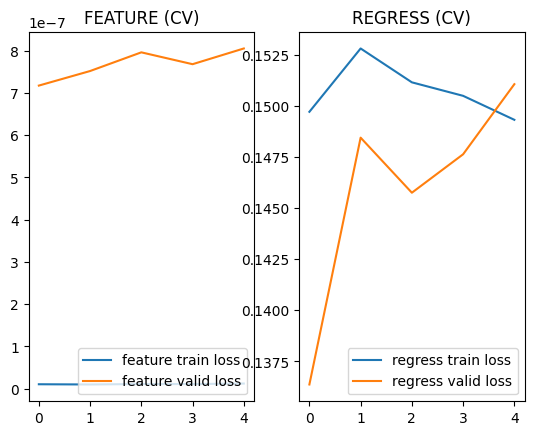

the best feature model is:    model_siamese/fea_round=0.pth
the best regression model is: model_siamese/reg_round=0.pth


In [117]:
# Theory suggests that when multiplying the batch size by k, 
# one should multiply the learning rate by sqrt(k) to keep the variance 
# in the gradient expectation constant. See page 5 at A. Krizhevsky. 
# One weird trick for parallelizing convolutional neural networks: 
# https://arxiv.org/abs/1404.5997
# 
# However, recent experiments with large mini-batches suggest for a simpler 
# linear scaling rule, i.e multiply your learning rate by k when using 
# mini-batch size of kN. See P.Goyal et al.: Accurate, Large Minibatch SGD: 
# Training ImageNet in 1 Hour 
# https://arxiv.org/abs/1706.02677
from pathlib import Path
from datetime import datetime
from sklearn.preprocessing import StandardScaler
import copy
print("it's training time")

n_epochs = 2000
batch_size = 128
feature_learning_rate = 5e-5
regress_learning_rate = 5e-5

"""model setup"""
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
feature_mdl = SiameseModel(device=device, input_dim=input_dimension)
regress_mdl = RegressionModel(device=device, input_dim=feature_dimension)

print("feature network params ct:")
print(f"\tnecessary params count: {2 * number_of_samples + input_dimension}")
feature_total_params = sum(p.numel() for p in feature_mdl.parameters())
print(f"\tactual params count: {feature_total_params}")
print("regress network params ct:")
print(f"\tnecessary params count: {2 * number_of_samples + feature_dimension}")
regress_total_params = sum(p.numel() for p in regress_mdl.parameters())
print(f"\tactual params count: {regress_total_params}")


feature_train_losses = []
feature_valid_losses = []
regress_train_losses = []
regress_valid_losses = []
print(f"number of epochs: {n_epochs}, batch size: {batch_size}, " + 
      f"device: {feature_mdl.device}, learning rates: {feature_learning_rate}, " +
      f"{regress_learning_rate}")
print()
print("training starts:")

Path(PATH).mkdir(parents=True, exist_ok=True)
saver = SaveBestModel_filename()
for cross_validation_round, (train, validate) in enumerate(zip(train_indices, validate_indices)):
    print(f"cross-validation round no.{cross_validation_round}")
    # use indices to extract training & testing set for current 
    # cross-validation round
    train_data, train_label = spectrum[train], temperature[train]
    validate_data, validate_label = spectrum[validate], temperature[validate]
    trainer_object = trainer(feature_model=feature_mdl,
                             regress_model=regress_mdl,
                             n_epochs=n_epochs,
                             batch_size=batch_size,
                             feature_learning_rate=feature_learning_rate,
                             regress_learning_rate=regress_learning_rate,
                             cross_validation_round=cross_validation_round)
    feature_valid_loss, feature_train_loss, feature_model, regress_valid_loss, regress_train_loss, regress_model = trainer_object.get_loss(
                                        train_data, 
                                        train_label, 
                                        validate_data, 
                                        validate_label)
    feature_train_losses.append(feature_train_loss)
    feature_valid_losses.append(feature_valid_loss)
    regress_train_losses.append(regress_train_loss)
    regress_valid_losses.append(regress_valid_loss)

    saver(current_loss=feature_valid_loss + regress_valid_loss, round=cross_validation_round)
    print(f"\tminimum feature train loss:      {feature_train_loss}")
    print(f"\tminimum feature valid loss:      {feature_valid_loss}")
    print(f"\t\tfeature val/train: {feature_valid_loss/feature_train_loss}")
    print(f"\tminimum regress train loss:      {regress_train_loss}")
    print(f"\tminimum regress valid loss:      {regress_valid_loss}")
    print(f"\t\tregress val/train: {regress_valid_loss/regress_train_loss}")
    print("\ttime: " + datetime.now().strftime("%Y-%m-%d %H:%M:%S"))
    if cross_validation_round == 0:
        break
        
print()
print("training and validation loss, across cross-validation rounds")
plt.subplot(1, 2, 1)
plt.plot(feature_train_losses)
plt.plot(feature_valid_losses)
plt.legend(["feature train loss", "feature valid loss"], loc ="lower right")
plt.title("FEATURE (CV)")
plt.subplot(1, 2, 2)
plt.plot(regress_train_losses)
plt.plot(regress_valid_losses)
plt.legend(["regress train loss", "regress valid loss"], loc ="lower right")
plt.title("REGRESS (CV)")
plt.show()

best_feature_model_filename = saver.current_best_model_1_filename
best_regress_model_filename = saver.current_best_model_2_filename
print(f"the best feature model is:    {best_feature_model_filename}")
print(f"the best regression model is: {best_regress_model_filename}")

In [118]:
print(np.asarray(feature_valid_losses).shape)
print(np.asarray(regress_valid_losses).shape)

(5,)
(5,)


In [119]:
# print()

print("loading best model")
best_feature_model = SiameseModel(device=device, input_dim=input_dimension)
print(best_feature_model.load_state_dict(torch.load(best_feature_model_filename)))
best_regress_model = RegressionModel(device=device, input_dim=feature_dimension)
print(best_regress_model.load_state_dict(torch.load(best_regress_model_filename)))
# print()

print("it's inference time!")
test = test_indices
test_data, test_label = spectrum[test], temperature[test]
test_set = SiameseDataset(
            test_data, 
            test_label)
loader_args = dict(batch_size=batch_size)
test_loader = DataLoader(test_set, shuffle=True, drop_last=True, 
                            **loader_args)
feature_test_losses = []
regress_test_losses = []
feature_test_criterion = FeatureLoss()
regress_test_criterion = nn.MSELoss()
for i, data in enumerate(test_loader, 0):
    with torch.no_grad():
        x1, x2, y1, y2, y1_raw, y2_raw = data
        # print(f"validate: shape of x1: {x1.shape}")
        f1 = best_feature_model(x1.to(device))
        f2 = best_feature_model(x2.to(device))

        y1_pred = best_regress_model(f1.to(device))
        regress_loss = regress_test_criterion(
            y1_pred.to(device), 
            y1_raw.to(device))
        regress_test_losses.append(regress_loss.item())

        feature_loss = feature_test_criterion(
            f1.to(device), 
            f2.to(device), 
            y1.to(device), 
            y2.to(device))
        real_feature_loss = feature_loss + 0
        feature_test_losses.append(real_feature_loss.item())
print(f"feature min validation losses: {np.min(feature_valid_losses)} " +
      f"  std: {np.std(feature_valid_losses)}") 
print(f"feature mean test loss: {np.mean(feature_test_losses)}")
print(f"\tfeature test/val: {np.mean(feature_test_losses)/np.min(feature_valid_losses)}")
print()
print(f"regress min validation losses: {np.min(regress_valid_losses)} " +  
    f"  std: {np.std(regress_valid_losses)}")
print(f"regress mean test loss: {np.mean(regress_test_losses)}") 
print(f"\tregress test/val: {np.mean(regress_test_losses)/np.min(regress_valid_losses)}")


loading best model
<All keys matched successfully>
<All keys matched successfully>
it's inference time!
feature min validation losses: 7.173482572397916e-07   std: 3.1600007720059046e-08
feature mean test loss: 3.8826245764135416e-07
	feature test/val: 0.5412468124412934

regress min validation losses: 0.1363730211855669   std: 0.005038505847165661
regress mean test loss: 0.15148288904203627
	regress test/val: 1.1107980722661333


In [120]:
print(np.asarray(feature_test_losses).shape)
print(np.asarray(regress_test_losses).shape)

(9,)
(9,)


In [121]:
number_figures = 10
import matplotlib.pyplot as plt

spec_normalize = preprocessing.normalize(np.copy(spectrum), axis=0)

indices = torch.randint(0, len(spectrum),(number_figures,)).unique()
for i in indices:
    print(f"we use {i}th example")
    # change: cast i to int, since pandas not work with torch.int64
    # changed: removed figure, since the output is just one number
    spec = np.asarray(spec_normalize[int(i)]).flatten()
    temp = np.asarray(temperature[int(i)]).flatten()
    
    # print(np.asarray(spectrum[int(i)]).flatten())
    # print(spec)
    feature = best_feature_model(torch.Tensor(spec).to(device))
    prediction = best_regress_model(feature).detach().cpu().flatten()
    
    prediction = prediction.item()
    ground_truth = temp.item()
    # recover data from normalization
    print(f"-----------------------------------------------------")
    print(f"\tthe prediction is: {prediction}")
    print(f"\tthe ground truth is: {ground_truth}")
    print(f"\tthe difference is: {prediction - ground_truth}")


we use 211th example
-----------------------------------------------------
	the prediction is: 21.151931762695312
	the ground truth is: 21.2
	the difference is: -0.04806823730468679
we use 498th example
-----------------------------------------------------
	the prediction is: 21.262432098388672
	the ground truth is: 21.8
	the difference is: -0.5375679016113288
we use 2416th example
-----------------------------------------------------
	the prediction is: 21.180349349975586
	the ground truth is: 21.2
	the difference is: -0.019650650024413352
we use 3518th example
-----------------------------------------------------
	the prediction is: 21.17249298095703
	the ground truth is: 21.7
	the difference is: -0.527507019042968
we use 4174th example
-----------------------------------------------------
	the prediction is: 21.24077606201172
	the ground truth is: 21.0
	the difference is: 0.24077606201171875
we use 4687th example
-----------------------------------------------------
	the prediction 

# **skip cell 14 for now (it's in template file!)**